Left percents: [14.5, 21.0, 22.6, 9.7, 24.2, 8.1]
Right percents: [17.3, 17.3, 15.4, 21.2, 11.5, 17.3]
Types in left_percentages: [<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]
Types in right_percentages: [<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]


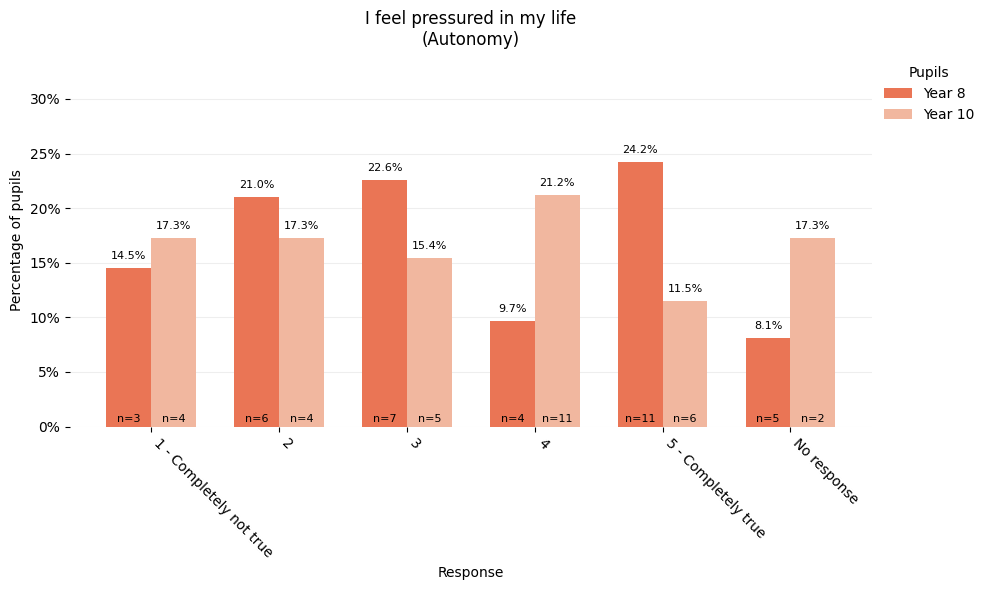

Processing school: School A
Processing subgroup: all_pupils
No data for all_pupils in topic All at school School A
Processing subgroup: year_group
Left percents: [14.516129032258066, 20.967741935483872, 22.58064516129032, 9.67741935483871, 24.193548387096776, 8.064516129032258]
Right percents: [17.307692307692307, 17.307692307692307, 15.384615384615385, 21.153846153846153, 11.538461538461538, 17.307692307692307]
Types in left_percentages: [<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]
Types in right_percentages: [<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]
Left percents: [25.806451612903224, 19.35483870967742, 14.516129032258066, 17.741935483870968, 19.35483870967742, 3.225806451612903]
Right percents: [15.384615384615385, 25.0, 17.307692307692307, 19.230769230769234, 21.153846153846153, 1.9230769230769231]
Types in left_percentages: [<class 'float'>, <class 'float'>, <clas

In [1]:
from typing import Literal
import pandas as pd
import ast
import matplotlib.pyplot as plt
import os
import math
import re
import csv
import io

from responses_double_comparison_graph import make_subgroup_comparison_graph


topic_name_dict = {
    "autonomy": "Autonomy",
    "life_satisfaction": "Life satisfaction",
    "optimism": "Optimism",
    "wellbeing": "Psychological wellbeing",
    "esteem": "Self-esteem",
    "stress": "Stress and coping",
    "appearance": "Feelings around appearance",
    "negative": "Negative affect",
    "lonely": "Loneliness",
    "support": "Supporting own wellbeing",
    "sleep": "Sleep",
    "physical": "Physical activity",
    "free_like": "Free time",
    "media": "Social media use",
    "places": "Places to go and things to do",
    "talk": "Talking about feelings",
    "accept": "Acceptance",
    "school_belong": "School connection",
    "staff_relationship": "Support from staff",
    "home_relationship": "Support from parents/carers",
    "home_happy": "Home environment",
    "local_env": "Local environment",
    "discrim": "Discrimination",
    "belong_local": "Local connection",
    "wealth": "Relative wealth",
    "future": "Future opportunities",
    "climate": "Climate change",
    "social": "Support from friends",
    "bully": "Bullying",
}


def clean_master_df(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = df.copy()

    columns_to_parse = ["cat", "cat_lab", "count", "percentage"]

    for column in columns_to_parse:
        df_copy[column] = df_copy[column].apply(lambda x: safe_parse(x, column))

    # Remove /n strings from measure_lab column (escaped)
    df_copy["measure_lab"] = df_copy["measure_lab"].str.replace("\\n", "")
    df_copy.dropna(subset=["count", "percentage"], inplace=True)
    return df_copy

# Define the labels dictionary at the top of your script
labels = {
    "autonomy_pressure": "I feel pressured in my life",
    "autonomy_express": "I generally feel free to express my ideas and opinions",
    "autonomy_decide": "I feel like I am free to decide for myself how to live my life",
    "autonomy_told": "In my daily life I often have to do what I am told",
    "autonomy_myself": "I feel I can pretty much be myself in daily situations",
    "autonomy_choice": "I have enough choice about how I spend my time",
    "life_satisfaction": "Overall, how satisfied are you with your life nowadays?",
    "optimism_future": "I am optimistic about my future",
    "optimism_best": "In uncertain times, I expect the best",
    "optimism_good": "I think good things are going to happen to me",
    "optimism_work": "I believe that things will work out, no matter how difficult they seem",
    "wellbeing_optimistic": "I've been feeling optimistic about the future",
    "wellbeing_useful": "I've been feeling useful",
    "wellbeing_relaxed": "I've been feeling relaxed",
    "wellbeing_problems": "I've been dealing with problems well",
    "wellbeing_thinking": "I've been thinking clearly",
    "wellbeing_close": "I've been feeling close to other people",
    "wellbeing_mind": "I've been able to make up my own mind about things",
    "esteem_satisfied": "On the whole, I am satisfied with myself",
    "esteem_qualities": "I feel that I have a number of good qualities",
    "esteem_well": "I am able to do things as well as most other people",
    "esteem_value": "I am a person of value",
    "esteem_good": "I feel good about myself",
    "stress_control": "During the last month, how often have you... felt you were unable to control the important things in your life?",
    "stress_overcome": "During the last month, how often have you... felt that difficulties were piling up so high that you could not overcome them?",
    "stress_confident": "During the last month, how often have you... felt confident about your ability to handle your personal problems?",
    "stress_way": "During the last month, how often have you... felt that things were going your way?",
    "appearance_happy": "How happy are you with your appearance (the way that you look)?",
    "appearance_feel": "My appearance affects how I feel about myself",
    "negative_lonely": "I feel lonely",
    "negative_unhappy": "I am unhappy",
    "negative_like": "Nobody likes me",
    "negative_cry": "I cry a lot",
    "negative_school": "I worry when I am at school",
    "negative_worry": "I worry a lot",
    "negative_sleep": "I have problems sleeping",
    "negative_wake": "I wake up in the night",
    "negative_shy": "I am shy",
    "negative_scared": "I feel scared",
    "lonely": "How often do you feel lonely?",
    "support_ways": "I have ways to support myself (e.g. to cope, or help myself feel better)",
    "support_look": "I know where to look for advice on how to support myself",
    "sleep": "Is the amount of sleep you normally get enough for you to feel awake and concentrate on your school work during the day?",
    "physical_days": "How many days in a usual week are you physically active?",
    "physical_hours": "How long on average do you spend being physically active?",
    "free_like": "How often can you do things that you like in your free time?",
    "media_hours": "On a normal weekday during term time, how much time do you spend on social media?",
    "places_freq": "How many activities/places are there in your local area that you choose to or would want to go to in your free time?",
    "places_barriers___1": "There's nothing to do",
    "places_barriers___2": "I'm unable to get there and back",
    "places_barriers___3": "It's too expensive (to get there or take part)",
    "places_barriers___4": "Poor weather",
    "places_barriers___5": "I have no-one to go with",
    "places_barriers___6": "It's too busy",
    "places_barriers___7": "I feel uncomfortable/anxious about other people who might be there",
    "places_barriers___8": "My parents/carers don't allow me to go",
    "places_barriers___9": "Other",
    "school_belong": "I feel that I belong at my school",
    "staff_interest": "At school there is an adult who... is interested in my schoolwork",
    "staff_believe": "At school there is an adult who... believes that I will be a success",
    "staff_best": "At school there is an adult who... wants me to do my best",
    "staff_listen": "At school there is an adult who... listens to me when I have something to say",
    "staff_talk": "Have you ever talked about feeling down with... an adult at school?",
    "staff_talk_listen": "Did you feel listened to when you spoke with... an adult at school?",
    "staff_talk_helpful": "Did you receive advice that you found helpful from... an adult at school?",
    "staff_talk_if": "How would you feel about speaking with... an adult at school?",
    "accept_staff": "Do you feel accepted as you are by... adults at your school?",
    "home_interest": "At home there is an adult who... is interested in my schoolwork",
    "home_believe": "At home there is an adult who... believes that I will be a success",
    "home_best": "At home there is an adult who... wants me to do my best",
    "home_listen": "At home there is an adult who... listens to me when I have something to say",
    "home_talk": "Have you ever talked about feeling down with... one of your parents/carers?",
    "home_talk_listen": "Did you feel listened to when you spoke with... one of your parents/carers?",
    "home_talk_helpful": "Did you receive advice that you found helpful from... one of your parents/carers?",
    "home_talk_if": "How would you feel about speaking with... one of your parents/carers?",
    "accept_home": "Do you feel accepted as you are... by your parents/carers?",
    "home_happy": "How happy are you with the home that you live in?",
    "local_safe": "How safe do you feel when in your local area?",
    "local_support": "People around here support each other with their wellbeing",
    "local_trust": "You can trust people around here",
    "local_neighbours": "I could ask for help or a favour from neighbours",
    "local_places": "There are good places to spend your free time (e.g., leisure centres, parks, shops)",
    "discrim_race": "How often do people make you feel bad because of... your race, skin colour or where you were born?",
    "discrim_gender": "How often do people make you feel bad because of... your gender?",
    "discrim_orientation": "How often do people make you feel bad because of... your sexual orientation?",
    "discrim_disability": "How often do people make you feel bad because of... disability?",
    "discrim_faith": "How often do people make you feel bad because of... your religion/faith?",
    "belong_local": "I feel like I belong in my local area",
    "accept_local": "Do you feel accepted as you are... by people in your local area?",
    "wealth": "Compared to your friends, is your family richer, poorer or about the same?",
    "future_options": "How many options are available?",
    "future_interest": "How do you feel about the options available?",
    "future_support": "Do you feel (or think you would feel) supported to explore options that interest you, even if no-one else around you has done them before?",
    "climate": "How often do you worry about the impact of climate change on your future?",
    "social_along": "I get along with people around me",
    "social_time": "People like to spend time with me",
    "social_support": "I feel supported by my friends",
    "social_hard": "My friends care about me when times are hard (for example if I am sick or have done something wrong)",
    "bully_physical": "How often do you get physically bullied at school? By this we mean getting hit, pushed around, threatened, or having belongings stolen.",
    "bully_other": "How often do you get bullied in other ways at school? By this we mean insults, slurs, name calling, threats, getting left out or excluded by others, or having rumours spread about you on purpose.",
    "bully_cyber": "How often do you get cyber-bullied? By this we mean someone sending mean text or online messages about you, creating a website making fun of you, posting pictures that make you look bad online, or sharing them with others.",
    "peer_talk": "Have you ever talked about feeling down with... another person your age?",
    "peer_talk_listen": "Did you feel listened to when you spoke with... another person your age?",
    "peer_talk_helpful": "Did you receive advice that you found helpful from... another person your age?",
    "peer_talk_if": "How would you feel about speaking with... another person your age?",
    "accept_peer": "Do you feel accepted as you are... by other people your age?",
}


SubGroups = Literal["all_pupils", "year_group", "gender", "fsm", "sen"]



def parse_list_string(s):
    """
    Parses a string representation of a list, handling quotes and commas correctly.

    Args:
        s (str): The string to parse, e.g., "['Very safe', 'Fairly safe', 'Don't know']"

    Returns:
        list: A list of parsed strings.
    """
    # Remove the outer brackets if present
    s = s.strip()
    if s.startswith("[") and s.endswith("]"):
        s = s[1:-1]

    # Use csv reader to handle quoted strings with commas and apostrophes
    reader = csv.reader(io.StringIO(s), skipinitialspace=True)
    try:
        parsed_list = next(reader)
    except StopIteration:
        parsed_list = []
    return parsed_list


def safe_parse(val, column):
    """
    Safely parses string representations of lists in the DataFrame columns.

    Args:
        val: The value to parse.
        column (str): The name of the column being parsed.

    Returns:
        list: The parsed list with appropriate data types.
    """
    # Handle NaN values (only for actual NaN, not string 'nan')
    if isinstance(val, float) and math.isnan(val):
        return []

    # Handle empty strings and None
    if val == "" or val is None:
        return []

    try:
        val = str(val).strip()

        # Ensure the string starts with '[' and ends with ']'
        if not (val.startswith("[") and val.endswith("]")):
            val = "[" + val + "]"

        if column == "cat_lab":
            # Use custom parser for 'cat_lab' to handle quotes and commas
            parsed_val = parse_list_string(val)
            return parsed_val
        else:
            # For 'count' and 'percentage' columns
            # Replace '\N' and 'nan' with '0' to handle missing or invalid values
            val = val.replace("\\N", "0").replace("nan", "0")

            # Safely evaluate the string to a Python list
            parsed_val = ast.literal_eval(val)

            # If the parsed value is a list, convert its items to floats
            if column in ["count", "percentage", "cat"] and isinstance(
                parsed_val, list
            ):
                numeric_list = []
                for item in parsed_val:
                    if item is None:
                        # Replace None with 0.0
                        numeric_list.append(0.0)
                    else:
                        try:
                            numeric_list.append(float(item))
                        except (ValueError, TypeError):
                            # If conversion fails, append 0.0
                            numeric_list.append(0.0)
                return numeric_list
            else:
                return parsed_val
    except (ValueError, SyntaxError) as e:
        print(f"Error parsing value in column '{column}': {val}. Error: {e}")
        return []  # Return empty list if parsing fails


def filter_rows_by_school(df: pd.DataFrame, school_name: str):
    df_copy = df.copy()
    df_copy = df_copy[df_copy["school_lab"] == school_name]
    return df_copy


def get_school_dfs(list_of_schools: list[str], df: pd.DataFrame):
    school_dfs = {}
    for school in list_of_schools:
        school_dfs[school] = filter_rows_by_school(df, school)
    return school_dfs


def filter_rows_by_topic(df: pd.DataFrame, topic_name: str):
    df_copy = df.copy()
    df_copy = df_copy[df_copy["group"] == topic_name]
    return df_copy


def filter_by_all_pupils(df: pd.DataFrame):
    df_copy = df.copy()
    df_copy = df_copy[
        (df_copy["year_group_lab"] == "All")
        & (df_copy["gender_lab"] == "All")
        & (df_copy["fsm_lab"] == "All")
        & (df_copy["sen_lab"] == "All")
    ]
    return df_copy


def filter_by_year_group(df: pd.DataFrame):
    df_copy = df.copy()
    df_copy = df_copy[
        (df_copy["year_group_lab"] == "Year 8")
        | (df_copy["year_group_lab"] == "Year 10")
    ]
    return df_copy


def filter_by_gender(df: pd.DataFrame):
    df_copy = df.copy()
    df_copy = df_copy[
        (df_copy["gender_lab"] == "Girl") | (df_copy["gender_lab"] == "Boy")
    ]
    return df_copy


def filter_by_fsm(df: pd.DataFrame):
    df_copy = df.copy()
    df_copy = df_copy[(df_copy["fsm_lab"] == "FSM") | (df_copy["fsm_lab"] == "Non-FSM")]
    return df_copy


def filter_by_sen(df: pd.DataFrame):
    df_copy = df.copy()
    df_copy = df_copy[(df_copy["sen_lab"] == "SEN") | (df_copy["sen_lab"] == "Non-SEN")]
    return df_copy


def filter_rows_by_subgroup(df: pd.DataFrame, subgroup_name: SubGroups):
    if subgroup_name == "all_pupils":
        return filter_by_all_pupils(df)
    if subgroup_name == "year_group":
        return filter_by_year_group(df)
    if subgroup_name == "gender":
        return filter_by_gender(df)
    if subgroup_name == "fsm":
        return filter_by_fsm(df)
    if subgroup_name == "sen":
        return filter_by_sen(df)


def get_measures(df: pd.DataFrame):
    measures = df["measure"].unique()
    return measures


def clean_filename(s):
    # Remove any illegal characters
    s = re.sub(r'[<>:"/\\|?*]', "", s)
    # Replace spaces with underscores
    s = s.replace(" ", "_")
    # Remove leading and trailing whitespace
    s = s.strip()
    # Truncate filename if it's too long
    return s[:255]  # Filesystems usually limit filenames to 255 characters


def save_graph(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.savefig(file_path, dpi=100)
    plt.close()


def single_comparison_graph(
    df: pd.DataFrame,
    measure_name: str,
    subgroup_name: str,
    topic_name: str,
    school: str,
):
    for _, data in df.iterrows():
        labels_list = data["cat_lab"]
        percentages = [float(x) for x in data["percentage"]]
        # Get the full measure label from the dictionary
        measure_label = labels.get(measure_name, data["measure_lab"])
        topic = data["group"]
        subgroup = subgroup_name

        if not labels_list or not percentages:
            print(f"Skipping measure '{measure_label}' due to empty data.")
            continue

        if len(labels_list) != len(percentages):
            print(f"Skipping measure '{measure_label}' due to mismatched lengths.")
            continue

        try:
            plt.figure(figsize=(10, 6))
            bars = plt.bar(labels_list, percentages, color="#ff7f0e", edgecolor="black")
            plt.title(
                f"{measure_label} - Percentages for {subgroup}",
                fontsize=16,
                fontweight="bold",
            )
            plt.xlabel("Category", fontsize=14)
            plt.ylabel("Percentage", fontsize=14)
            plt.xticks(rotation=45, ha="right", fontsize=12)
            plt.yticks(fontsize=12)
            plt.grid(
                True,
                which="both",
                linestyle="--",
                linewidth=0.5,
                color="gray",
                axis="y",
            )

            # Add data labels on top of the bars
            for bar in bars:
                height = bar.get_height()
                plt.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + max(percentages) * 0.01,
                    f"{height:.1f}%",
                    ha="center",
                    va="bottom",
                    fontsize=12,
                )

            plt.tight_layout()
            # Clean the measure label for use in the filename
            filename = clean_filename(measure_label) + "_percentages.png"
            save_graph(f"outputs/{school}/responses/{subgroup}/{topic}/{filename}")
        except Exception as e:
            print(f"Error creating graph for {measure_label}: {e}")


def make_graphs_for_single_comparison(
    df: pd.DataFrame, subgroup_name: str, topic_name: str, school: str
):
    if df.empty:
        print(f"No data for {subgroup_name} in topic {topic_name} at school {school}")
        return
    measures = get_measures(df)
    for measure in measures:
        measure_df = df[df["measure"] == measure]
        single_comparison_graph(measure_df, measure, subgroup_name, topic_name, school)


def multiple_comparison_graph(
    df: pd.DataFrame,
    measure_name: str,
    labels_list: list[str],
    subgroup_name: str,
    topic_name: str,
    school: str,
):
    percentages_list = []

    for label in labels_list:
        # Adjust the filtering to match the appropriate subgroup label columns
        if subgroup_name == "gender":
            filtered_df = df[df["gender_lab"] == label]
        elif subgroup_name == "fsm":
            filtered_df = df[df["fsm_lab"] == label]
        elif subgroup_name == "sen":
            filtered_df = df[df["sen_lab"] == label]
        elif subgroup_name == "year_group":
            filtered_df = df[df["year_group_lab"] == label]
        else:
            continue  # Skip if subgroup_name doesn't match

    if filtered_df.empty:
        # Dont make a graph
        raise AttributeError("DF is empty.")

    # Get the full measure label from the dictionary
    measure_label = labels.get(measure_name, measure_name)
    topic = topic_name
    subgroup = subgroup_name

    if not labels_list or not percentages_list:
        print(f"Skipping measure '{measure_label}' due to empty data.")
        return

    if len(labels_list) != len(percentages_list):
        print(f"Skipping measure '{measure_label}' due to mismatched lengths.")
        return

    try:
        plt.figure(figsize=(10, 6))
        bars = plt.bar(
            labels_list, percentages_list, color="#ff7f0e", edgecolor="black"
        )
        plt.title(
            f"{measure_label} - Percentage Comparison for {subgroup}",
            fontsize=16,
            fontweight="bold",
        )
        plt.xlabel(subgroup.capitalize(), fontsize=14)
        plt.ylabel("Percentage", fontsize=14)
        plt.xticks(rotation=45, ha="right", fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(
            True, which="both", linestyle="--", linewidth=0.5, color="gray", axis="y"
        )

        # Add data labels on top of the bars
        for bar, percentage in zip(bars, percentages_list):
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                height + max(percentages_list) * 0.01,
                f"{percentage:.1f}%",
                ha="center",
                va="bottom",
                fontsize=12,
            )

        plt.tight_layout()
        # Clean the measure label for use in the filename
        filename = clean_filename(measure_label) + "_percentages_comparison.png"
        save_graph(f"outputs/{school}/responses/{subgroup}/{topic}/{filename}")
    except Exception as e:
        print(f"Error creating comparison graph for {measure_label}: {e}")


def get_label_list_rows(*, df, labels_list, subgroup_name):
    rows = []

    if subgroup_name == "gender":
        for label in labels_list:
            rows.append(df[df["gender_lab"] == label])
    elif subgroup_name == "fsm":
        for label in labels_list:
            rows.append(df[df["fsm_lab"] == label])
    elif subgroup_name == "sen":
        for label in labels_list:
            rows.append(df[df["sen_lab"] == label])
    elif subgroup_name == "year_group":
        for label in labels_list:
            rows.append(df[df["year_group_lab"] == label])

    return rows

def make_graph_for_subgroup_row(
    df: pd.DataFrame, subgroup_name: SubGroups, topic_name: str, school_name: str
):
    """
    e.g., topic_name = Autonomy
    e.g., school_name = School A
    e.g., subgroup_name = year_group
    """
    if df.empty:
        print(
            f"No data for {subgroup_name} in topic {topic_name} at school {school_name}"
        )
        return

    # Define the correct labels based on the subgroup
    if subgroup_name == "gender":
        labels_list = ["Girl", "Boy"]
    elif subgroup_name == "fsm":
        labels_list = ["FSM", "Non-FSM"]
    elif subgroup_name == "sen":
        labels_list = ["SEN", "Non-SEN"]
    elif subgroup_name == "year_group":
        labels_list = ["Year 8", "Year 10"]
    else:
        print(f"Unknown subgroup: {subgroup_name}. Skipping.")
        return

    # Create multiple comparison graphs for the filtered data
    measures = get_measures(df)
    for measure in measures:
        measure_df: pd.DataFrame = df[df["measure"] == measure]

        rows = get_label_list_rows(
            df=measure_df, labels_list=labels_list, subgroup_name=subgroup_name
        )

        assert len(rows) == 2, "Not 2 rows, this is an error. It should be 'Year 8, Year 10' etc"

        # Display topic names
        display_topic_name = topic_name_dict.get(topic_name, topic_name)

        # **Corrected Zipping Process**
        try:
            # Extract the first element (the list) from each Series
            percentages_group1 = rows[0]["percentage"].iloc[0]
            percentages_group2 = rows[1]["percentage"].iloc[0]
            counts_group1 = rows[0]["count"].iloc[0]
            counts_group2 = rows[1]["count"].iloc[0]
        except (IndexError, AttributeError) as e:
            print(f"Error accessing data for measure '{measure}': {e}")
            continue

        # Now, zip the individual elements
        percentages_tuple_list = list(zip(percentages_group1, percentages_group2))
        counts_tuple_list = list(zip(counts_group1, counts_group2))

        assert len(percentages_tuple_list) == len(
            counts_tuple_list
        ), "Length of percents and counts not the same... this is an error."

        _fig = make_subgroup_comparison_graph(
            category_label=measure_df.iloc[0]["cat_lab"],
            percentages=percentages_tuple_list,
            counts_list=counts_tuple_list,
            topic=display_topic_name,
            measure_label=labels[measure],
            comparison_groups=labels_list,
            legend_title="Pupils",
        )

        filename = clean_filename(measure) + "_percentages_comparison.png"
        filepath = f"outputs/{school_name}/responses/{subgroup_name}/{topic_name}/{filename}"
        save_graph(filepath)

def make_single_comparison_graph(
    df: pd.DataFrame, subgroup_name: SubGroups, topic_name: str, school_name: str
):
    make_graphs_for_single_comparison(df, subgroup_name, topic_name, school_name)


def make_graphs_for_all_pupils(df: pd.DataFrame, topic_name, school_name):
    # Generate graphs for all pupils
    make_single_comparison_graph(
        df,
        subgroup_name="all_pupils",
        topic_name=topic_name,
        school_name=school_name,
    )


def make_graphs_for_subgroup(
    df: pd.DataFrame, subgroup_name: SubGroups, topic_name: str, school_name: str
):
    if df.empty:
        print(
            f"No data for {subgroup_name} in topic {topic_name} at school {school_name}"
        )
        return
    if subgroup_name == "all_pupils":
        make_graphs_for_all_pupils(df, topic_name=topic_name, school_name=school_name)
    else:
        # For other subgroups, directly make graphs using the filtered data
        make_graph_for_subgroup_row(
            df,
            subgroup_name=subgroup_name,
            topic_name=topic_name,
            school_name=school_name,
        )


def make_all_graphs(master_df: pd.DataFrame):
    plt.style.use("seaborn-v0_8-whitegrid")
    plt.rcParams.update(
        {
            "font.family": "Arial",
            "font.size": 12,
            "axes.titlesize": 16,
            "axes.titleweight": "bold",
            "axes.labelsize": 14,
            "xtick.labelsize": 12,
            "ytick.labelsize": 12,
            "legend.fontsize": 12,
            "figure.figsize": (10, 6),
        }
    )

    # Clean the master DataFrame
    cleaned_master_df = clean_master_df(master_df)

    # Get the list of schools and topics from the DataFrame
    list_of_schools = cleaned_master_df["school_lab"].unique()
    topics = cleaned_master_df["group"].unique()

    # Define the subgroups
    subgroups = ["all_pupils", "year_group", "gender", "fsm", "sen"]

    # Get the DataFrames for each school
    school_dfs = get_school_dfs(list_of_schools, cleaned_master_df)

    # Loop through each school
    for school_name, school_df in school_dfs.items():
        print(f"Processing school: {school_name}")
        # Loop through each subgroup
        for subgroup_name in subgroups:
            print(f"Processing subgroup: {subgroup_name}")
            # Filter the DataFrame for the subgroup
            subgroup_df = filter_rows_by_subgroup(school_df, subgroup_name)
            # Loop through each topic
            for topic_name in topics:
                # Filter the DataFrame for the topic
                topic_df = filter_rows_by_topic(subgroup_df, topic_name)
                # Make graphs for the subgroup and topic
                make_graphs_for_subgroup(
                    topic_df,
                    subgroup_name=subgroup_name,
                    topic_name=topic_name,
                    school_name=school_name,
                )


# Read in data
master_df = pd.read_csv(
    "../data/synthetic/standard/clean_synthetic_standard_survey.standard_school_aggregate_responses.0000000010000.csv",
    encoding="utf-8",
    encoding_errors="ignore",
    on_bad_lines="skip",
)


cleaned_df = clean_master_df(master_df)

make_all_graphs(cleaned_df)
